In [1]:
import os
import math

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.python.keras.api import keras
from tensorflow.keras.utils import timeseries_dataset_from_array

from hpcscripts.sharedutils.trainingutils import LoadModel, SetLowTFVerbose, MakeSinglePrediction
from hpcscripts.sharedutils.nomalization import DF_Nomalize, denorm
from hpcscripts.sharedutils.modelutils import SelectModelPrompt
from hpcscripts.option import pathhandler as ph
from hpcscripts.option import globalparams as G_PARAMS

SetLowTFVerbose()

2022-05-30 19:20:18.789417: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-30 19:20:18.839846: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudnn.so.8'; dlerror: libcudnn.so.8: cannot open shared object file: No such file or directory
2022-05-30 19:20:18.839872: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1835] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2022-05-30 19:20:18.840779: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN

In [2]:
# Importing Files
def get_file_list ():
    combined_path = ph.GetProcessedPath("Cleaned")
    files = os.listdir(combined_path)
    files = [os.path.join(combined_path, file) for file in files]
    return files

def create_temp_files(file_list, rel_start=-400, rel_end=50):

    new_list = []

    temp_dir = ph.GetProcessedPath("Temp")
    if not os.path.exists(temp_dir):
        os.makedirs(temp_dir)

        for i, file in enumerate (file_list):
            _df = pd.read_csv(file)
            _newfile = os.path.join(temp_dir, os.path.basename(file))
            new_list.append(_newfile)
            
            _app_end_ind = int (_df.loc[1, 'fParam'])
            _df = _df.loc[ (_app_end_ind+rel_start): (_app_end_ind+rel_end-1) , :]
            
            _df.to_csv(_newfile, index=False)
            print (f".. i = {i}/{len(file_list)}", end='\r')

    else:
        for file in file_list:
            _newfile = os.path.join(temp_dir, os.path.basename(file))
            new_list.append(_newfile)
    
    print ("Finished Processing Files")

    return new_list

def import_DFs(file_list):

    df_list = []

    for i, file in enumerate (file_list):
        _df = pd.read_csv(file)
        df_list.append(_df)

    return df_list

In [4]:
old_file_list = get_file_list()
file_list = create_temp_files(old_file_list)

df_list = import_DFs(file_list)

len(df_list)

Finished Processing Files


550

In [5]:
# Plot column

def plot_column(df_list, column, alpha=.02):
    
    _x = [i for i in range(df_list[0].shape[0])]

    for i, _df in enumerate (df_list):        
        _app_end_ind = int (_df.loc[1, 'fParam'])
        _y = _df.loc[:, column]
        
        plt.plot(_x, _y, alpha=alpha, color='red')
        print (f".. i = {i}/{len(file_list)}", end='\r')
    
    print ("Finished                  ")
    plt.show()

Finished                  


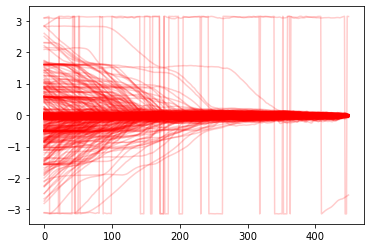

In [6]:
plot_column(df_list, "psi_rad", alpha=.2)

(450, 60)

In [42]:
# filter usable df

passed_dfs = []
passed_dfs_i = []
total_len = df_list[0].shape[0]
psi_thres = .05
_3deg_mult = 1000 * math.tan(3*math.pi/180)

for i, df in enumerate(df_list):
    
    if abs(df.loc[0, 'psi_rad']) > psi_thres:
        continue
    if abs(df.loc[30, 'psi_rad']) > psi_thres:
        continue
    if abs(df.loc[total_len-300, 'psi_rad']) > psi_thres:
        continue
    if abs(df.loc[total_len-250, 'psi_rad']) > psi_thres:
        continue
    if abs(df.loc[total_len-200, 'psi_rad']) > psi_thres:
        continue
    if abs(df.loc[total_len-100, 'psi_rad']) > psi_thres:
        continue
    if abs(df.loc[total_len-50, 'psi_rad']) > psi_thres:
        continue

    if abs(df.loc[150, 'hralt_m']) > 600:
        continue
    if abs(df.loc[100, 'hralt_m']) > 600:
        continue
    if abs(df.loc[50, 'hralt_m']) > 600:
        continue

    if abs(df.loc[150, 'dist_to_land']*_3deg_mult - df.loc[150, 'hralt_m']) > 20:
        continue
    if abs(df.loc[100, 'dist_to_land']*_3deg_mult - df.loc[100, 'hralt_m']) > 20:
        continue

    passed_dfs.append(df)
    passed_dfs_i.append(i)

len (passed_dfs)

4

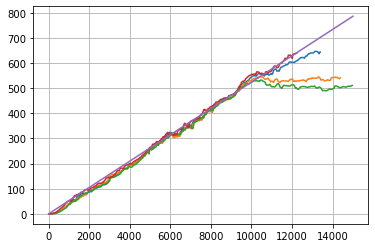

In [46]:
_x = [i for i in range(df_list[0].shape[0])]
_x_dist = [i for i in range(15000)]
_y_3deg = [math.tan(3*math.pi/180) * i for i in range(15000)]

for df in passed_dfs:
    # plt.plot(_x, df.loc[:, 'hralt_m'])
    plt.plot(df.loc[:, 'dist_to_land']*1000, df.loc[:, 'hralt_m'])

plt.grid(True)
plt.plot(_x_dist, _y_3deg)
plt.show()

In [45]:
for i in passed_dfs_i:
    print (file_list[i])


/home/ikhwansh/Datas/Cool Yeah/TeA/HPC_Scripts/Data/Processed/Temp/flight_23067.csv
/home/ikhwansh/Datas/Cool Yeah/TeA/HPC_Scripts/Data/Processed/Temp/flight_31077.csv
/home/ikhwansh/Datas/Cool Yeah/TeA/HPC_Scripts/Data/Processed/Temp/flight_10603.csv
/home/ikhwansh/Datas/Cool Yeah/TeA/HPC_Scripts/Data/Processed/Temp/flight_23366.csv


In [ ]:
column = "pla_1_rad"

_max = -999
_min = 999

for i, file in enumerate(old_file_list):
    _df = pd.read_csv(file)
    _col = _df.loc[:, column]

    if _col.max() > _max:
        _max = _col.max()
    if _col.min() < _min:
        _min = _col.min()

print (f"min: {_min}")
print (f"max: {_max}")

In [ ]:
_min * 180 / math.pi

In [ ]:
_max * 180 / math.pi

In [ ]:
97.859375

In [52]:
0.611147823935186*180/math.pi

35.01619097009047